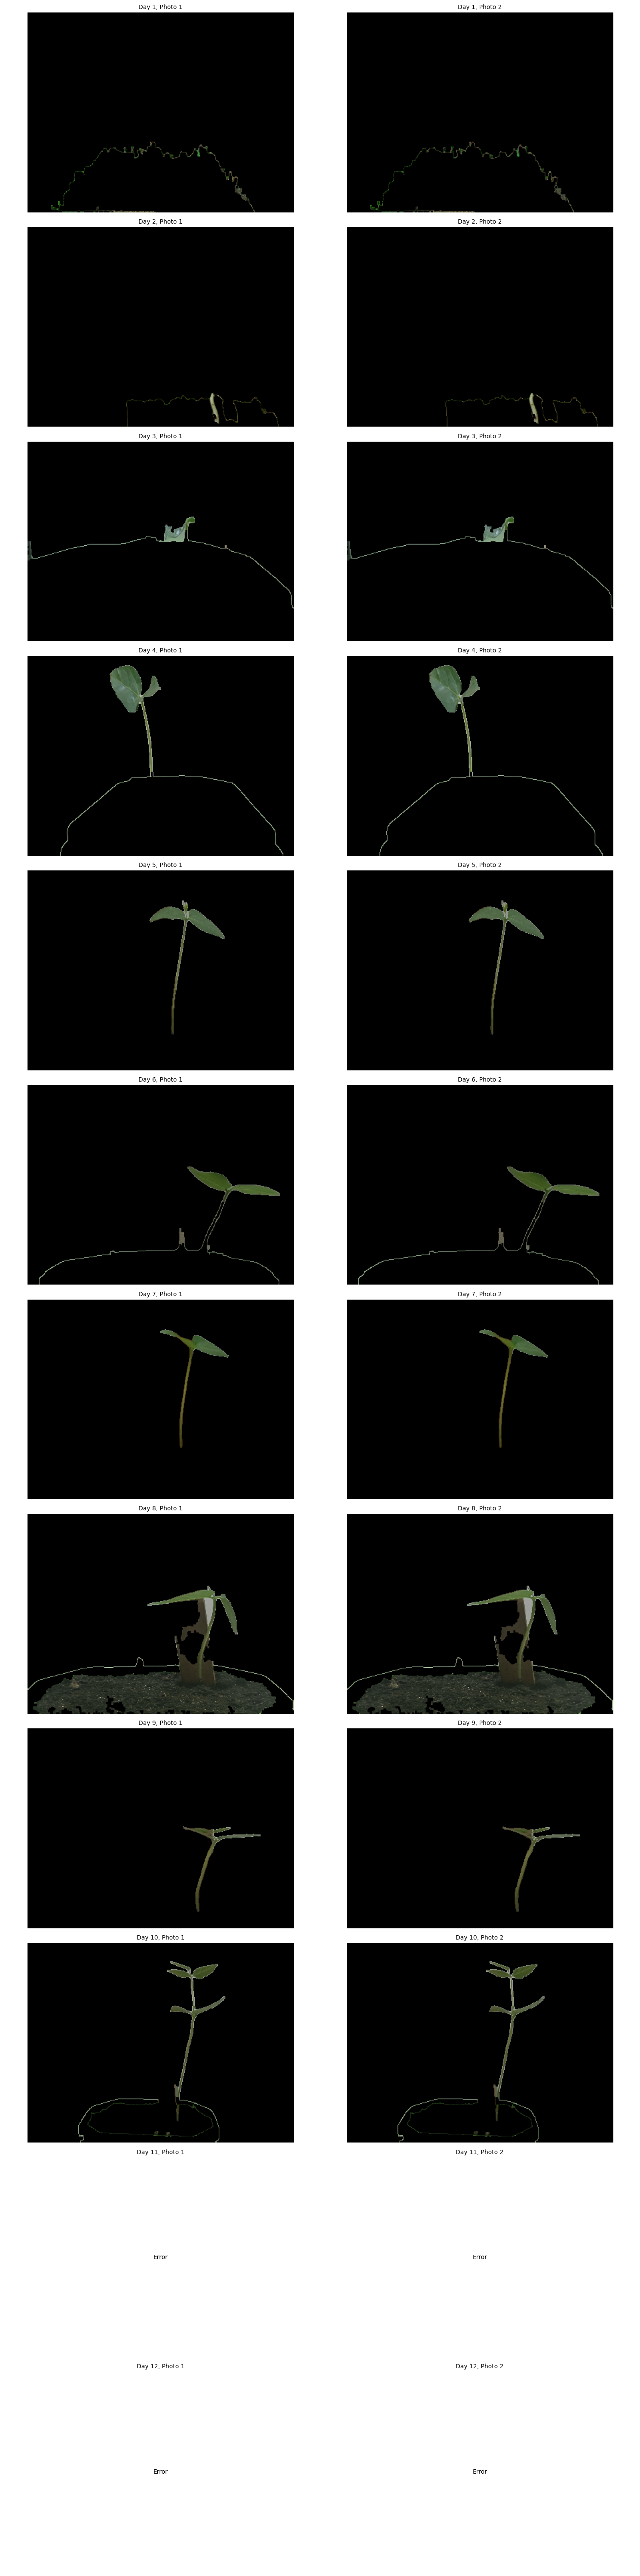

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def segment_image(img_path):
    """
    Segments the plant from the background in an image using color-based segmentation.
    """
    # Read the image
    image = cv2.imread(img_path)
    if image is None:
        return None

    # Resize the image for consistency
    image = cv2.resize(image, (400, 300))

    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define HSV range for green color (adjust as needed)
    lower = np.array([25, 50, 50])  # Lower bound for green
    upper = np.array([90, 255, 255])  # Upper bound for green

    # Create a mask for the green areas
    mask = cv2.inRange(hsv, lower, upper)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(mask, (5, 5), 0)

    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Dilate and erode to clean up the edges
    dilate_kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, dilate_kernel, iterations=1)
    cleaned = cv2.erode(dilated, dilate_kernel, iterations=1)

    # Find contours in the cleaned mask
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None

    # Find the largest contour (assumed to be the plant)
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the largest contour
    contour_mask = np.zeros_like(mask)
    cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Apply the mask to the original image to extract the plant
    plant = cv2.bitwise_and(image, image, mask=contour_mask)

    return plant


# **Settings**
days = 12  # Number of days of photos
photos_per_day = 2  # Number of photos per day (e.g., morning/evening shots)
base_dir = "side images\morning\M2"  # Base directory containing images

# **Create a grid for visualization**
fig, axs = plt.subplots(days, photos_per_day, figsize=(15, days * 5))

for day in range(1, days + 1):
    for photo_num in range(1, photos_per_day + 1):
        img_path = os.path.join(base_dir, f"day {day}.jpg")
        
        # Segment the plant from the image
        plant = segment_image(img_path)

        if plant is not None:
            # Display segmented plant in the grid
            axs[day - 1][photo_num - 1].imshow(cv2.cvtColor(plant, cv2.COLOR_BGR2RGB))
        else:
            # Display "Error" if segmentation fails or file not found
            axs[day - 1][photo_num - 1].text(0.5, 0.5, "Error", ha="center", va="center", fontsize=10)
        
        axs[day - 1][photo_num - 1].axis("off")
        axs[day - 1][photo_num - 1].set_title(f"Day {day}, Photo {photo_num}", fontsize=10)

# Adjust layout and display the grid
plt.tight_layout()
plt.show()
